In [1]:
# for folders one level below the heirarchy
import sys
import os 
current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir, os.pardir))
sys.path.append(parent_dir)

from aodfunctions.dependencies import *
from aodfunctions.general import *
from aodfunctions.settings import *
from aodfunctions.testbed import *
# from aodfunctions.outofplane import *

cupyon=True

try: 
    import cupy as cp
    import cupyx.scipy.fft as cpfft
    import cupyx.scipy.ndimage
    from cupyx.scipy.ndimage import gaussian_filter1d as cp_gaussian_filter1d
    from cupyx.scipy.ndimage import gaussian_filter as cp_gaussian_filter
    from cupyx.scipy.ndimage import affine_transform as cp_affine_transform
    from cupy.lib.stride_tricks import as_strided

except ImportError:
    cp = np
    cpfft = spfft
    cp_gaussian_filter1d = sp_gaussian_filter1d
    cp_gaussian_filter = sp_gaussian_filter
    cp_affine_transform = sp_affine_transform
    cupyon = False
    from numpy.lib.stride_tricks import as_strided
    print("cupy not installed. Using numpy.")


Cycletime in nanoseconds:  11538.461538461537
Aod pixel pitch in microns:  14.999999999999998
Fourier space spacing in microns:  0.09331054687500001
Fourier space aperture in microns:  382.20000000000005
Timestep in nanoseconds: 23.076923076923077


In [2]:
## Global Variables - REMEMBER TO UPDATE SETTINGS WHEN CHANGED
# Hardware-defined Constants. Note that all explicit variable values are in position (m), frequency (1/m), or time (s). Conversions are done explicitly to relevant time/distance scales.
aodaperture = 7.5e-3 # Aperture size of the AOD
soundvelocity = 650   # Sound velocity in the medium
cycletime = aodaperture / soundvelocity  # Time for one cycle of the waveform
focallength = 9.1 * 10**(-3) # mm
wavelength = 630 * 10**(-9)

print("Cycletime in nanoseconds: ", cycletime * 1e9)

# Simulation Constants
numpix_frame = 500
numpix_real = 4096
pixelsize_real = aodaperture / numpix_frame
aperturesize_real = numpix_real * pixelsize_real
aperturesize_fourier = wavelength * focallength / (pixelsize_real)
pixelsize_fourier = aperturesize_fourier / numpix_real
print("Aod pixel pitch in microns: ", pixelsize_real*1e6)
print("Fourier space spacing in microns: ", pixelsize_fourier*10**6)
print("Fourier space aperture in microns: ", aperturesize_fourier*10**6)

# Adjustable Variables
movementtime = 205*10**(-6) # Time for the movement of the AOD
timestep = cycletime / numpix_frame
print("Timestep in nanoseconds:", timestep * 10**9)
startlocation = -20*10**(-6) # Start location of the AOD in microns. 0 is set to the center of Fourier space.
endlocation = 20*10**(-6) # End location of the AOD in microns


optimizationbasisfunctions = 'Chebyshev'  # Basis for the polynomial fit
numcoefficients = 100

num_particles = 10000
atommass = 1.41922*10**(-25) # Mass of the atom
tweezerdepth = 10*10**6 # Depth of the tweezer in Hertz
hbar = 6.626*10**(-34)


globalvariables = [aodaperture, soundvelocity, cycletime, focallength, wavelength, numpix_frame, numpix_real, pixelsize_real, aperturesize_real, aperturesize_fourier, pixelsize_fourier, movementtime, timestep, startlocation, endlocation, num_particles, atommass, tweezerdepth, hbar, optimizationbasisfunctions, numcoefficients]
aodaperture, soundvelocity, cycletime, focallength, wavelength, numpix_frame, numpix_real, pixelsize_real, aperturesize_real, aperturesize_fourier, pixelsize_fourier, movementtime, timestep, startlocation, endlocation, num_particles, atommass, tweezerdepth, hbar, optimizationbasisfunctions, numcoefficients = globalvariables



Cycletime in nanoseconds:  11538.461538461537
Aod pixel pitch in microns:  14.999999999999998
Fourier space spacing in microns:  0.09331054687500001
Fourier space aperture in microns:  382.20000000000005
Timestep in nanoseconds: 23.076923076923077


In [3]:
### From the global variables, initialize the AWG waveform
numpix_waveform = int(movementtime / cycletime * numpix_frame) + 2* numpix_frame # Why is there a 2* cycletime here? To add on the initial and final stages of the AOD. We will only change the portion in the movement time and fix the ends.
AWGwaveform = cp.zeros(numpix_waveform)

print("Tweezer starting positions:", startlocation*10**6, "microns or", micronstoMHz(startlocation, globalvariables) /10**6, "MHz")
print("Tweezer ending positions:", endlocation*10**6, "microns or", micronstoMHz(endlocation, globalvariables) /10**6, "MHz")
print("One micron corresponds to", micronstoMHz(1e-6, globalvariables) /10**6, "MHz")
print(len(AWGwaveform))

Tweezer starting positions: -20.0 microns or -2.267573696145124 MHz
Tweezer ending positions: 20.0 microns or 2.267573696145124 MHz
One micron corresponds to 0.1133786848072586 MHz
9883


In [4]:
optimized_position, optimized_velocity, optimized_acceleration, optimized_jerk, time  = initpath_sinsqramp_general(globalvariables)

fourierpixels, time = positionstofourier(optimized_position, time, globalvariables)

expanded_position, expanded_time = expand_position_array(time, fourierpixels, globalvariables)
expanded_acceleration, expanded_time = expand_position_array(time, optimized_acceleration, globalvariables)

AWGinitguess = initguess_waveform(AWGwaveform, optimized_position, time, globalvariables)
AWGinitguesscosine = cosinephaseresponse(AWGinitguess)
AWGinitguessexponential = exponentialphaseresponse(AWGinitguess)
# init_forces = retrieveforces(AWGinitguessexponential, globalvariables, 10, True)
# init_potentials = retrievepotentials(AWGinitguessexponential, globalvariables, 10, True)

fittedwaveform, fittedlegendre = init_opt_waveformfitLegendre(AWGinitguess, 1000, globalvariables)

c:\ProgramData\Anaconda3\lib\site-packages\numpy\polynomial\legendre.py:1412: RankWarning: The fit may be poorly conditioned
  return pu._fit(legvander, x, y, deg, rcond, full, w)


Maximum error: 2.692332827791688e-07


In [5]:
# class EField:
#     def __init__(self,  globalvariables):
#         """
#         Initializes the field, representing the cross-section profile of a plane wave

#         Parameters
#         ----------
#         wavelength: wavelength of the plane wave
#         extent_x: length of the rectangular grid 
#         extent_y: height of the rectangular grid 
#         Nx: horizontal dimension of the grid 
#         Ny: vertical dimension of the grid 
#         intensity: intensity of the field
#         """
#         aodaperture, soundvelocity, cycletime, focallength, wavelength, numpix_frame, numpix_real, pixelsize_real, aperturesize_real, aperturesize_fourier, pixelsize_fourier, movementtime, timestep, startlocation, endlocation, num_particles, atommass, tweezerdepth, hbar, optimizationbasisfunctions, numcoefficients = globalvariables

#         self.extent_x = numpix_frame * pixelsize_fourier
#         self.dx = pixelsize_fourier

#         self.x = cp.linspace(0, numpix_frame * pixelsize_fourier, numpix_frame) -numpix_frame * pixelsize_fourier / 2
#         self.xx = self.x

#         self.Nx = numpix_frame
#         self.E = cp.zeros(numpix_frame) * cp.exp(1j * 0)
#         self.λ = wavelength
#         self.z = 0

# def lens(flength, globalvariables):
#     aodaperture, soundvelocity, cycletime, focallength, wavelength, numpix_frame, numpix_real, pixelsize_real, aperturesize_real, aperturesize_fourier, pixelsize_fourier, movementtime, timestep, startlocation, endlocation, num_particles, atommass, tweezerdepth, hbar, optimizationbasisfunctions, numcoefficients = globalvariables
#     xx = cp.linspace(0, numpix_frame * pixelsize_fourier, numpix_frame) -numpix_frame * pixelsize_fourier / 2
#     fresnellens = cp.exp(-1j * cp.pi / (wavelength * flength) * (xx**2))
#     return fresnellens

# def propogate_bluestein(self, E, dz, x_interval, globalvariables, scalefactor = 1):
#     aodaperture, soundvelocity, cycletime, focallength, wavelength, numpix_frame, numpix_real, pixelsize_real, aperturesize_real, aperturesize_fourier, pixelsize_fourier, movementtime, timestep, startlocation, endlocation, num_particles, atommass, tweezerdepth, hbar, optimizationbasisfunctions, numcoefficients = globalvariables
#     self.z += dz
#     λ = wavelength


#     E = bluestein_fft(E * cp.exp(1j * 2*cp.pi/λ /(2*dz) *(self.xx**2)), 
#                     f0=x_interval[0] / (dz*λ), f1=x_interval[1] / (dz*λ), fs=1/self.dx, M=numpix_frame, axis=0)

#     dfx = 1/(self.Nx*self.dx)

#     fx_zfft = bluestein_fftfreq(x_interval[0]/ (dz*λ),x_interval[1]/ (dz*λ), self.Nx)
#     dfx_zfft = fx_zfft[1]-fx_zfft[0]


#     nn = (cp.linspace(0,(self.Nx-1),self.Nx)*dfx_zfft/dfx )
#     factor = (self.dx* cp.exp(cp.pi*1j * (nn)))


#     self.x = fx_zfft*(dz*λ)

#     self.xx = self.x

#     self.dx = self.x[1] - self.x[0]

#     self.extent_x = self.x[1] - self.x[0] + self.dx
#     E = E*factor * cp.exp(1j*cp.pi/(λ*dz) * (self.xx**2)  +   1j*2*cp.pi/λ * dz ) / (1j*dz*λ)
#     self.E = E

#     return E

# def bluestein_fft(x, axis, f0, f1, fs, M):
#     """
#     bluestein FFT function to evaluate the DFT
#     coefficients for the rows of an array in the frequency range [f0, f1]
#     using N points.
    
#     Parameters
#     ----------

#     x: array to evaluate DFT (along last dimension of array)
#     f0: lower bound of frequency bandwidth
#     f1: upper bound of frequency bandwidth
#     fs: sampling frequency
#     M: number of points used when evaluating the 1DFT (N <= signal length)
#     axis: axis along which the fft's are computed (defaults to last axis)


#     Reference: 
    
#     Leo I. Bluestein, “A linear filtering approach to the computation of the discrete Fourier transform,” 
#     Northeast Electronics Research and Engineering Meeting Record 10, 218-219 (1968).
#     """
#     # Swap axes
#     x = cp.swapaxes(a=x, axis1=axis, axis2=-1)

#     # Normalize frequency range
#     phi0 = 2.0 * cp.pi * f0 / fs
#     phi1 = 2.0 * cp.pi * f1 / fs
#     d_phi = (phi1 - phi0) / (M - 1)

#     # Determine shape of signal
#     A = cp.exp(1j * phi0)
#     W = cp.exp(-1j * d_phi)
#     X = chirpz(x=x, A=A, W=W, M=M)

#     return cp.swapaxes(a=X, axis1=axis, axis2=-1)

# def bluestein_fftfreq(f0, f1, M):
#     """
#     Return frequency values of the bluestein FFT
#     coefficients returned by bluestein_fft().
    
#     Parameters
#     ----------

#     f0: lower bound of frequency bandwidth
#     f1: upper bound of frequency bandwidth
#     fs: sampling rate
    
#     """

#     df = (f1 - f0) / (M - 1)
#     return cp.arange(M) * df + f0

# def chirpz(x, A, W, M):
#     """
    
#     Parameters
#     ----------

#     x: array to evaluate chirp-z transform (along last dimension of array)
#     A: starting point of chirp-z contour
#     W: controls frequency sample spacing and shape of the contour
#     M: number of frequency sample points

#     Reference:
#     Rabiner, L.R., R.W. Schafer and C.M. Rader. The Chirp z-Transform
#     Algorithm. IEEE Transactions on Audio and Electroacoustics,
#     AU-17(2):86--92, 1969

#     Originally Written by Stefan van der Walt: 
#     http://www.mail-archive.com/numpy-discussion@scipy.org/msg01812.html
    
#     The discrete z-transform,
#     X(z) = \sum_{n=0}^{N-1} x_n z^{-n}
#     is calculated at M points,
#     z_k = AW^-k, k = 0,1,...,M-1
#     for A and W complex, which gives
#     X(z_k) = \sum_{n=0}^{N-1} x_n z_k^{-n}
#     """

#     x = cp.asarray(x, dtype=complex)
#     P = x.shape

#     N = P[-1]
#     L = int(2 ** cp.ceil(cp.log2(M + N - 1)))

#     n = cp.arange(N, dtype=float)
#     y = cp.power(A, -n) * cp.power(W, n ** 2 / 2.)
#     y = cp.tile(y, (P[0], 1)) * x
#     Y = cp.fft.fft(y, L)

#     n = cp.arange(L, dtype=float)
#     v = cp.zeros(L, dtype=complex)

#     v[:M] = cp.power(W, -n[:M] ** 2 / 2.)
#     v[L-N+1:] = cp.power(W, -(L - n[L-N+1:]) ** 2 / 2.)

#     V = cp.fft.fft(v)

#     g = cp.fft.ifft(cp.tile(V, (P[0], 1)) * Y)[:,:M]
#     k = cp.arange(M)
#     g = g * cp.tile(cp.power(W, k ** 2 / 2.), (P[0],1))

#     # Return result
#     return g

def array_1dto2d(arr, N):
    """
    Stacks a 1D array into a 2D array by repeating it N times along the rows.

    Parameters:
    arr (np.ndarray): The 1D array to be stacked.
    N (int): The number of times to repeat the 1D array along the rows.

    Returns:
    np.ndarray: The resulting 2D array.
    """
    # Ensure the input is a 1D array
    if arr.ndim != 1:
        raise ValueError("Input array must be 1-dimensional")

    # Use np.tile to repeat the array N times along a new axis
    result = cp.tile(arr, (N, 1))
    
    return result

In [ ]:
import diffractsim
diffractsim.set_backend("CUDA") #Change the string to "CUDA" to use GPU acceleration

from diffractsim import MonochromaticField, Lens, nm, mm, cm, RectangularSlit

In [58]:
%%time

test2d = array_1dto2d(AWGinitguessexponential[0:500], 20)
F = MonochromaticField(
    wavelength = 632.8 * nm, extent_x=20. * mm, extent_y=20. * mm, Nx=500, Ny=20, intensity =2.
)

for i in range(1,1000):
    test2d = array_1dto2d(AWGinitguessexponential[i:i+500], 20)
    F = MonochromaticField(
        wavelength = 632.8 * nm, extent_x=20. * mm, extent_y=20. * mm, Nx=500, Ny=20, intensity =2.
    )
    F.E = test2d
    F.add(Lens(focallength))


    # propagate the field and scale the viewing extent four times: (new_extent_x = old_extent_x * 4 = 80* mm)
    #F.scale_propagate(400*cm, scale_factor = 4)
    F.zoom_propagate(focallength, x_interval = [startlocation - 1e-5, endlocation+1e-5], y_interval = [- 1e-6, +1e-6])


    # plot the intensity
    I = F.get_intensity()
# F.plot_intensity(I, square_root = True, units = mm, grid = True, figsize = (14,5), slice_y_pos = 0*mm)


Wall time: 4.76 s


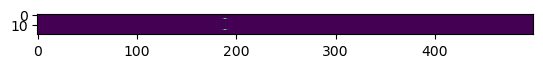

In [59]:
plt.imshow(I.get())

c:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


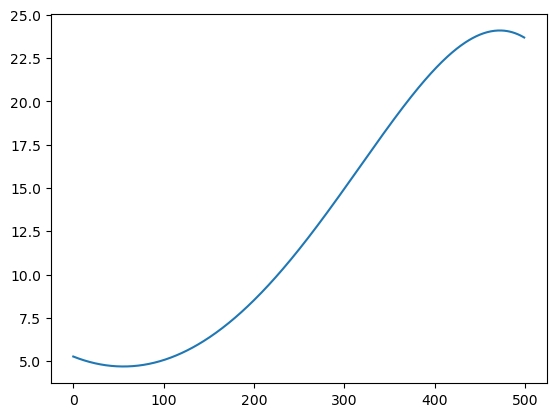

In [123]:
field = EField(globalvariables)
E0 = AWGinitguessexponential[0:500] * lens(focallength, globalvariables)
testout = propogate_bluestein(field, E0, focallength, [startlocation-1e-5, endlocation+1e-5], globalvariables)
plt.plot(testout[0].get())

c:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


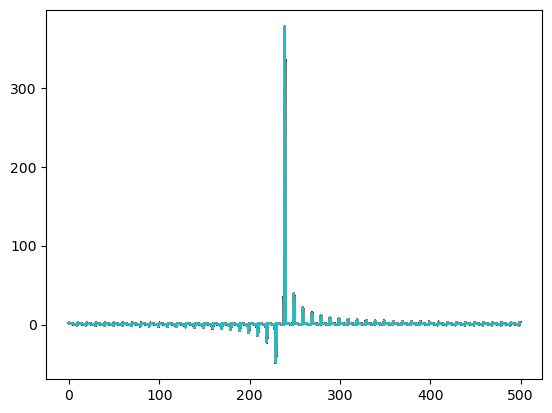

In [57]:
plt.plot(bluestein_fft(AWGinitguessexponential[0:500], 0, 5,10,0.1,500).get())

In [172]:
import cupy as cp

def bilinear_interpolation(z, x, zz, xx, potential_slices):
    """
    Perform bilinear interpolation for a given set of coordinates.

    Parameters:
    z (float): Z-coordinate.
    x (float): X-coordinate.
    zz (cupy.ndarray): Z-coordinates grid.
    xx (cupy.ndarray): X-coordinates grid.
    potential_slices (cupy.ndarray): Array of potential slices.

    Returns:
    float: Interpolated potential value.
    """
    
    z_idx = cp.searchsorted(zz[:, 0], cp.array(int(z))) - 1
    x_idx = cp.searchsorted(xx[0, :],  cp.array(int(x))) - 1

    z1 = zz[z_idx, 0]
    z2 = zz[z_idx + 1, 0]
    x1 = xx[0, x_idx]
    x2 = xx[0, x_idx + 1]

    Q11 = potential_slices[z_idx, x_idx]
    Q12 = potential_slices[z_idx, x_idx + 1]
    Q21 = potential_slices[z_idx + 1, x_idx]
    Q22 = potential_slices[z_idx + 1, x_idx + 1]

    return (
        Q11 * (z2 - z) * (x2 - x) +
        Q21 * (z - z1) * (x2 - x) +
        Q12 * (z2 - z) * (x - x1) +
        Q22 * (z - z1) * (x - x1)
    ) / ((z2 - z1) * (x2 - x1))

def interpolate_potential_cp(potential_slices, xspacing, zspacing):
    """
    Interpolate a 2D potential profile from slices using CuPy.

    Parameters:
    potential_slices (cupy.ndarray): Array of 1D arrays, each representing a slice of the potential along the x-axis.
    xspacing (float): Spatial spacing of each pixel in each frame.
    zspacing (float): Spatial spacing in the z-direction between each frame.

    Returns:
    cupy.ndarray: Interpolated 2D potential profile.
    """
    potential_slices = cp.asarray(potential_slices)
    num_slices, num_points = potential_slices.shape
    z_coords = cp.arange(num_slices) * zspacing
    x_coords = cp.arange(num_points) * xspacing

    zz, xx = cp.meshgrid(z_coords, x_coords, indexing='ij')
    return potential_slices, zz, xx

def compute_gradient_cp(potential_2d, xspacing, zspacing):
    """
    Compute the gradient of a 2D potential profile using CuPy.

    Parameters:
    potential_2d (cupy.ndarray): 2D potential profile.
    xspacing (float): Spatial spacing of each pixel in each frame.
    zspacing (float): Spatial spacing in the z-direction between each frame.

    Returns:
    tuple: Gradients in the x and z directions.
    """
    grad_x = (cp.roll(potential_2d, -1, axis=1) - cp.roll(potential_2d, 1, axis=1)) / (2 * xspacing)
    grad_z = (cp.roll(potential_2d, -1, axis=0) - cp.roll(potential_2d, 1, axis=0)) / (2 * zspacing)
    
    return grad_x, grad_z

def interpolate_gradient_cp(grad_x, grad_z, coordinates, zz, xx):
    """
    Interpolate the gradient at given coordinates using CuPy.

    Parameters:
    grad_x (cupy.ndarray): Gradient in the x direction.
    grad_z (cupy.ndarray): Gradient in the z direction.
    coordinates (list of tuples): List of (z, x) coordinates.

    Returns:
    list of tuples: Interpolated gradient (dx, dz) at the given coordinates.
    """
    gradients = []
    for z, x in coordinates:
        dx = bilinear_interpolation(z, x, zz, xx, grad_x)
        dz = bilinear_interpolation(z, x, zz, xx, grad_z)
        gradients.append((dx, dz))
        
    return gradients

# Example usage
potential_slices = cp.array([cp.linspace(-10, 10, 100)**2 for _ in range(50)])  # Example slices
xspacing = 0.1
zspacing = 0.2

# Interpolate potential
potential_slices, zz, xx = interpolate_potential_cp(potential_slices, xspacing, zspacing)

# Compute gradient
grad_x, grad_z = compute_gradient_cp(potential_slices, xspacing, zspacing)

# Interpolate gradient at given coordinates
coordinates = [(20.0, 20.0), (7.0, 11)]  # Example coordinates
interpolated_gradients = interpolate_gradient_cp(grad_x, grad_z, coordinates, zz, xx)

# Print results
print("Interpolated gradients at given coordinates:")
for coord, grad in zip(coordinates, interpolated_gradients):
    print(f"At {coord}: dx = {grad[0]}, dz = {grad[1]}")


Interpolated gradients at given coordinates:
At (20.0, 20.0): dx = 60.80187653496505, dz = 0.0
At (7.0, 11): dx = 24.441950367876313, dz = -0.0


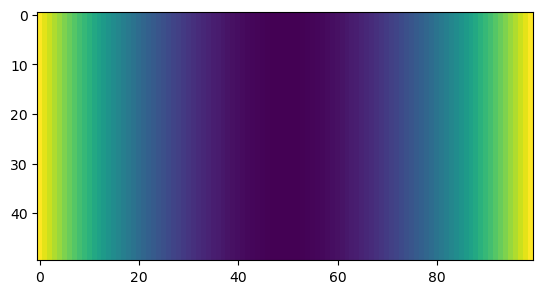

In [156]:
plt.imshow(potential_slices.get())

c:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


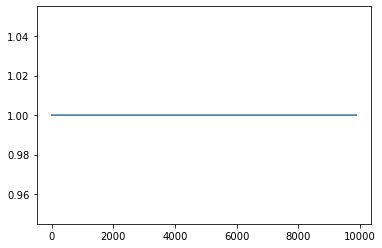

In [10]:
plt.plot((AWGinitguessexponential * cp.conjugate(AWGinitguessexponential)).get())

In [7]:
test1 = get_atomsurvivalfromwaveform(AWGinitguessexponential, 40e-6, 10, globalvariables)

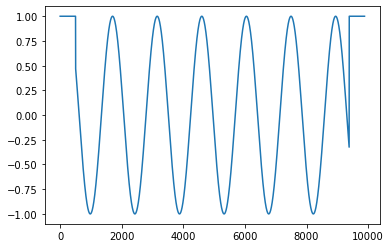

In [6]:
testexp = cp.zeros(len(AWGinitguessexponential))
testexp[0:numpix_frame] = 1
testexp[-numpix_frame:] = 1
optimizationreg = cp.linspace(0, len(AWGinitguessexponential) / numpix_real, len(AWGinitguessexponential))[numpix_frame:-numpix_frame]
testexp[numpix_frame:-numpix_frame] = cp.exp(1j * ((len(AWGinitguessexponential)-2*numpix_frame) / (numpix_frame) *optimizationreg + 112) )
plt.plot(testexp.get())

In [20]:
modifiedwaveform = AWGinitguessexponential * testexp
test2 = get_atomsurvivalfromwaveform(AWGinitguessexponential, 10e-6, 10, globalvariables)

In [21]:
test2

0.1547

In [ ]:
0.0864 -> 

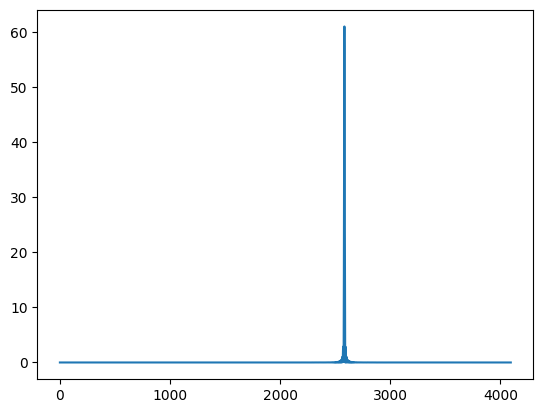

4.112822880227772
2583.8687489948843
10000
waveform made
forces made
xout retrieved 10000
survivalprobability retrieved
0.4959
waveform made
forces made
xout retrieved 10000
survivalprobability retrieved
0.4959
waveform made
forces made
xout retrieved 10000
survivalprobability retrieved
0.2685
waveform made
forces made
xout retrieved 10000
survivalprobability retrieved
0.1804
waveform made
forces made
xout retrieved 10000
survivalprobability retrieved
0.3898
waveform made
forces made
xout retrieved 10000
survivalprobability retrieved
0.4322
waveform made
forces made
xout retrieved 10000
survivalprobability retrieved
0.4724
waveform made
forces made
xout retrieved 10000
survivalprobability retrieved
0.4953
waveform made
forces made
xout retrieved 10000
survivalprobability retrieved
0.4961
waveform made
forces made
xout retrieved 10000
survivalprobability retrieved
0.4961
waveform made
forces made
xout retrieved 10000
survivalprobability retrieved
0.3005
waveform made
forces made
xout re

In [6]:
optimizedwaveform, optimizedLegendre, AWGwave_template = opt_atomsurvival_Legendre(fittedwaveform, fittedlegendre, 100e-6, globalvariables)
# optimizedwaveform, optimizedLegendre = opt_atomsurvival_PhaseOnly(AWGinitguess,500, 1e-6, globalvariables)
# optimizedwaveform, optimizedLegendre, AWGwave_template = opt_forces_Legendre(fittedwaveform, expanded_position, expanded_acceleration, fittedlegendre, globalvariables)


In [7]:
optimized_forces = retrieveforces(exponentialphaseresponse(optimizedwaveform), globalvariables, 10, True)
optimized_potentials = retrievepotentials(exponentialphaseresponse(optimizedwaveform), globalvariables, 10, True)

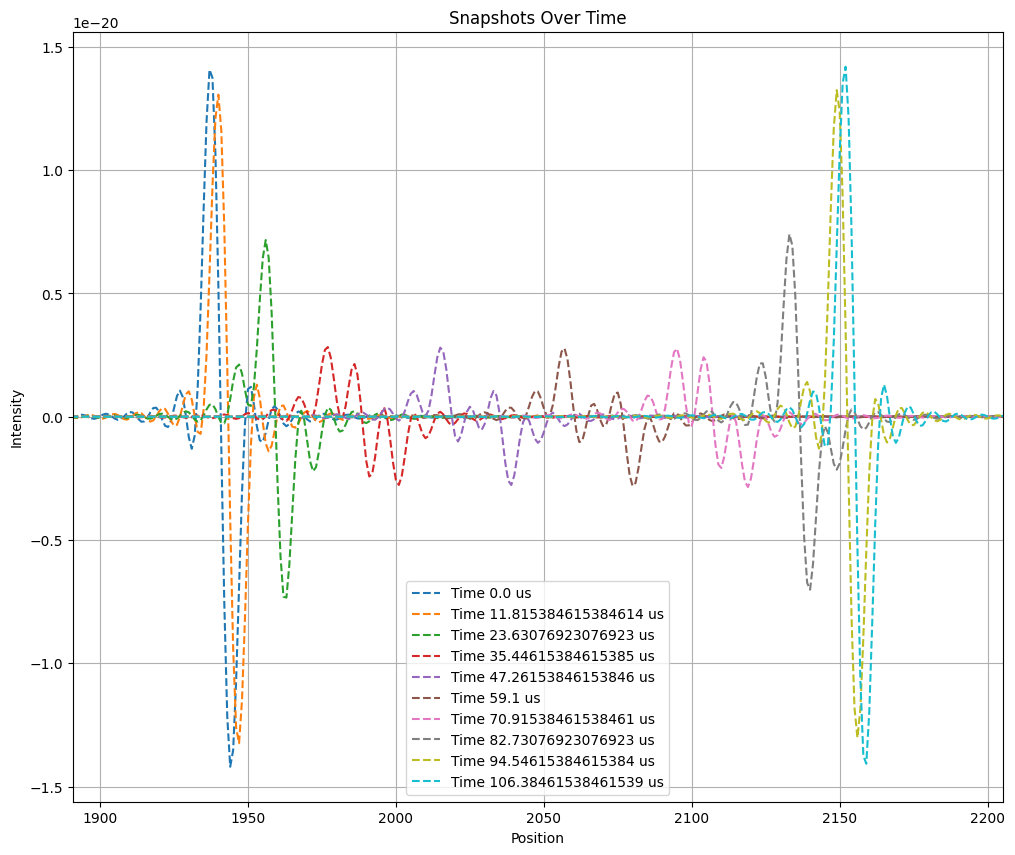

In [10]:


def plot_snapshots(frames, numsnapshots, globalvariables, figuresize = (10,6),filterOn=True):
    """
    Plot the frames of an input array at multiple points in time. Final graph has all the plots overlaid.
    
    Parameters:
    frames (cp.ndarray): Array of frames, each of which contains a 1D array representing a snapshot.
    numsnapshots (int): Number of snapshots to plot, evenly distributed throughout the frames array.
    globalvariables (dict): A dictionary of global variables.
    filterOn (bool, optional): Whether to apply an xlim filter to the snapshots. Default is True.
    """
    aodaperture, soundvelocity, cycletime, focallength, wavelength, numpix_frame, numpix_real, pixelsize_real, aperturesize_real, aperturesize_fourier, pixelsize_fourier, movementtime, timestep, startlocation, endlocation, num_particles, atommass, tweezerdepth, hbar, optimizationbasisfunctions, numcoefficients = globalvariables

    # Convert cupy array to numpy array for compatibility with matplotlib
    frames = tonumpy(frames)
    
    # Calculate the indices for the snapshots to plot
    indices = np.linspace(0, len(frames) - 1, numsnapshots, dtype=int)
    
    plt.figure(figsize=figuresize)
    
    for idx in indices:
        snapshot = frames[idx]
        
        # Plot each snapshot
        plt.plot(snapshot, '--', label=f'Time {idx * timestep*10**6} us')
    
    if filterOn:
        # Apply xlim filter based on global variables
        xlim_min = positionstofourier(startlocation, 0, globalvariables)[0] - 50
        xlim_max = positionstofourier(endlocation, 0, globalvariables)[0] + 50
        plt.xlim(xlim_min, xlim_max)
    
    plt.xlabel('Position')
    plt.ylabel('Intensity')
    plt.title('Snapshots Over Time')
    plt.legend()
    plt.grid(True)
    
    plt.show()

plot_snapshots(init_forces, 10, globalvariables, (12,10), filterOn=True)


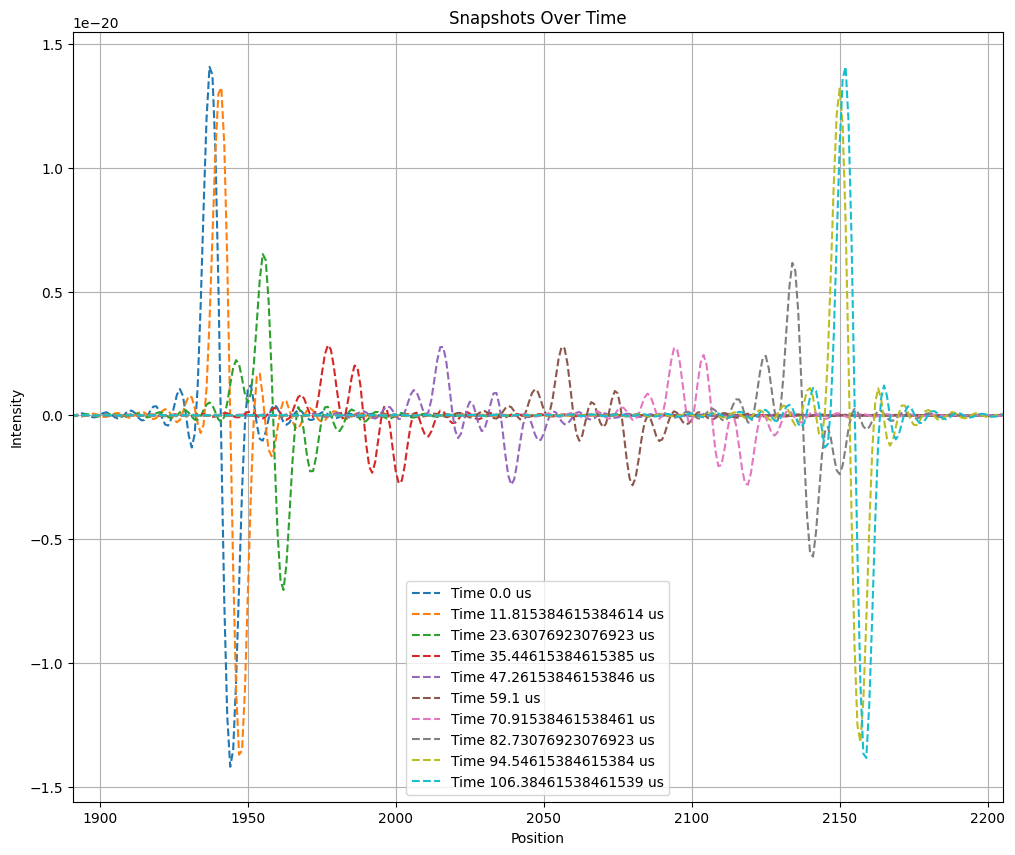

In [9]:
plot_snapshots(optimized_forces, 10, globalvariables, (12,10), filterOn=True)


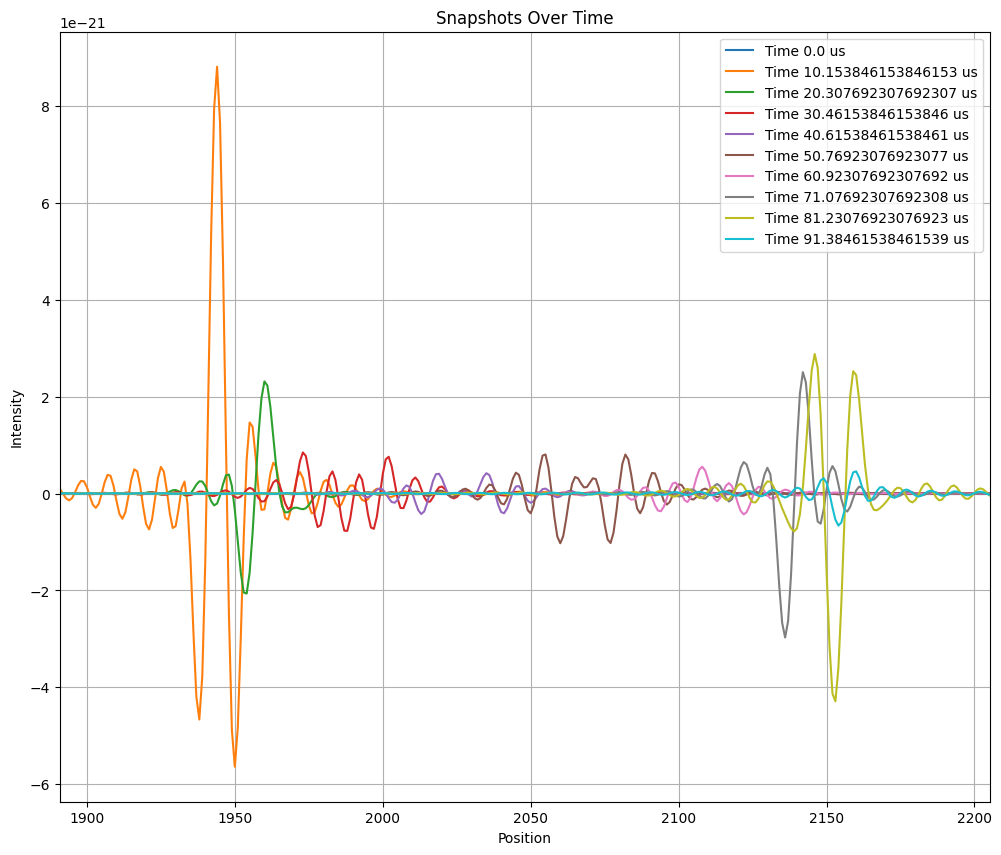

In [13]:
plot_snapshots(optimized_forces - init_forces, 10, globalvariables, (12,10), filterOn=True)


(1800.0, 2000.0)

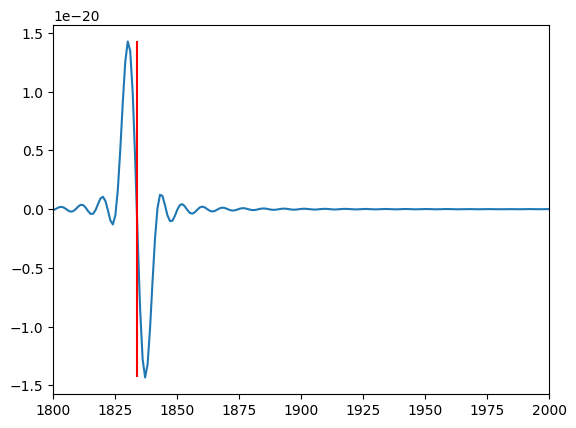

In [41]:
plt.plot(init_forces[0])
plt.vlines(x=positionstofourier(endlocation, time, globalvariables)[0], ymin = init_forces[0].min(), ymax = init_forces[0].max(), color = 'r')
plt.vlines(x=positionstofourier(startlocation, time, globalvariables)[0], ymin = init_forces[0].min(), ymax = init_forces[0].max(), color = 'r')
plt.xlim(1800,2000)

In [41]:
expanded_position

array([1833.66195709, 1833.66212   , 1833.66228292, ..., 2262.33771708,
       2262.33788   , 2262.33804291])

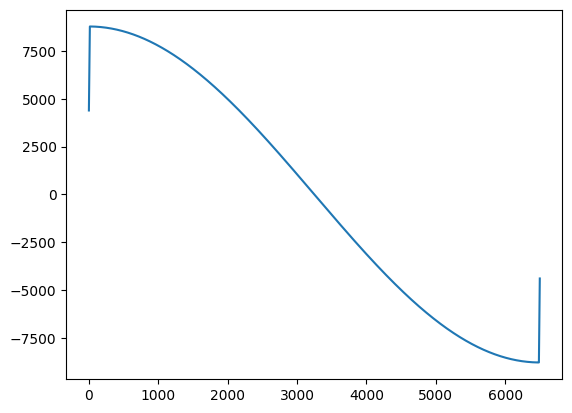

In [43]:
plt.plot(expanded_acceleration)

In [ ]:
optimized_position, optimized_velocity, optimized_acceleration, optimized_jerk, time  = initpath_sinsqramp(globalvariables)

fourierpixels, time = positionstofourier(optimized_position, time, globalvariables)
expanded_position, expanded_time = expand_position_array(time, fourierpixels, globalvariables)

AWGinitguess = initguess_waveform(AWGwaveform, optimized_position, time, globalvariables)
AWGinitguesscosine = cosinephaseresponse(AWGinitguess)
AWGinitguessexponential = exponentialphaseresponse(AWGinitguess)

fittedwaveform, fittedlegendre = init_opt_waveformfitLegendre(AWGinitguess, 1000, globalvariables)

In [7]:
movetimes = np.arange(210,250,10)*10**(-6)
movetemperatures = np.array([1])*10**(-6)

# movetimes = np.array([200])*10**(-6)
# movetemperatures = np.array([1])*10**(-6)


# ideallinear = analyze_fixeddistance_nonoptimized(movetimes,movetemperatures,"Exponential","Ideal", "Linear", 1, globalvariables)
# notideallinear = analyze_fixeddistance_nonoptimized(movetimes,movetemperatures,"Exponential","Not Ideal", "Linear", 1, globalvariables)
# idealsinsq = analyze_fixeddistance_nonoptimized(movetimes,movetemperatures,"Exponential","Ideal", "SinSq", 1, globalvariables)
notidealsinsq = analyze_fixeddistance_nonoptimized(movetimes,movetemperatures,"Exponential","Not Ideal", "SinSq", 10, globalvariables)
# optimizedsinsq = analyze_fixeddistance_optimized(movetimes,movetemperatures,"Exponential","Not Ideal", "SinSq", 10, globalvariables)

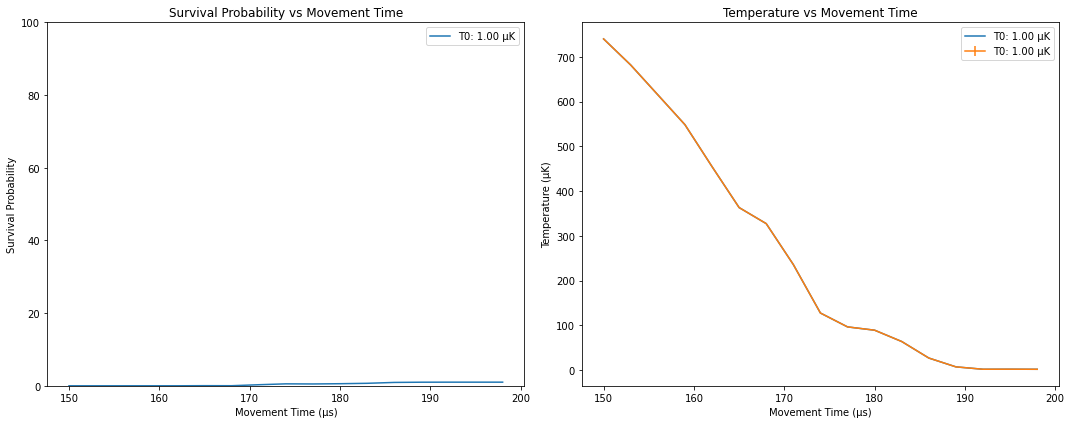

In [6]:
plots_fixeddistance(movetimes, movetemperatures, notidealsinsq)

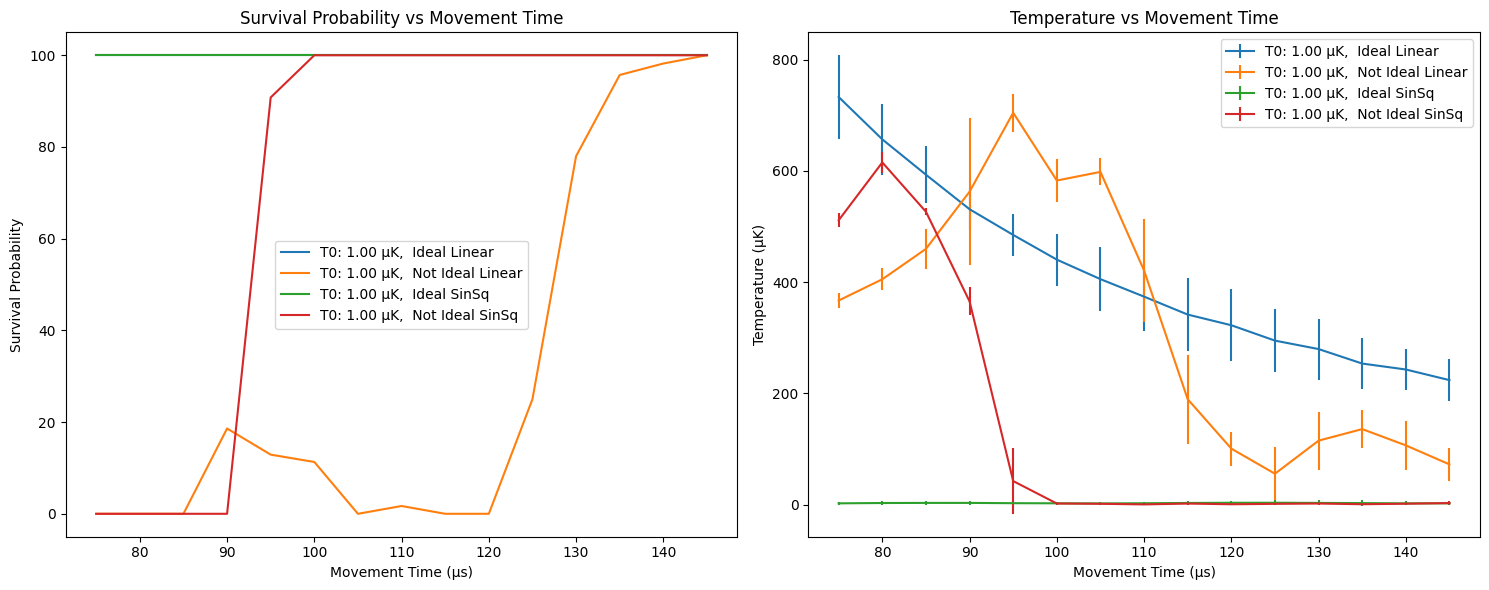

In [55]:
plots_fixeddistance_multipleanalysis(movetimes, movetemperatures, np.array([ideallinear, notideallinear, idealsinsq, notidealsinsq]), np.array(["Ideal Linear", "Not Ideal Linear", "Ideal SinSq", "Not Ideal SinSq"]))

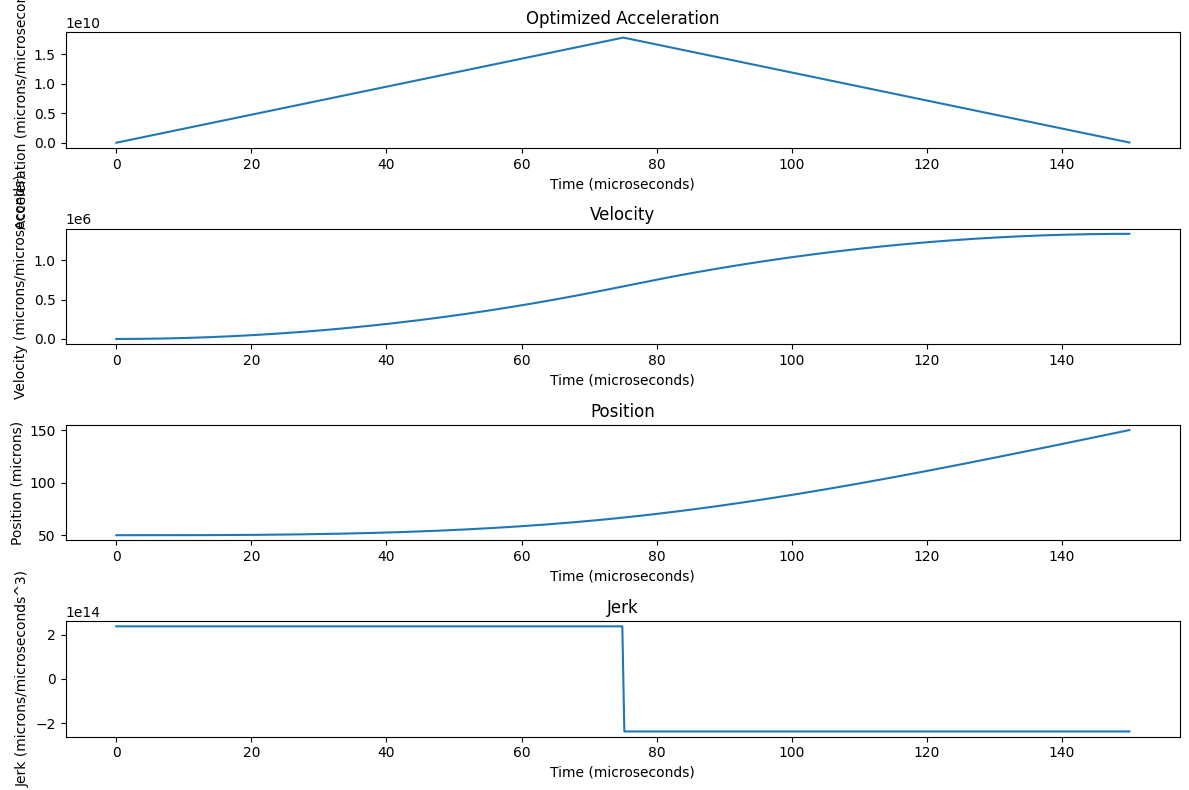

In [ ]:
plt.figure(figsize=(12, 8))

plt.subplot(4, 1, 1)
plt.plot(time * 10**6, optimized_acceleration * 10**6)
plt.title('Optimized Acceleration')
plt.xlabel('Time (microseconds)')
plt.ylabel('Acceleration (microns/microseconds^2)')

plt.subplot(4, 1, 2)
plt.plot(time* 10**6, optimized_velocity* 10**6)
plt.title('Velocity')
plt.xlabel('Time (microseconds)')
plt.ylabel('Velocity (microns/microseconds)')

plt.subplot(4, 1, 3)
plt.plot(time* 10**6, optimized_position* 10**6)
plt.title('Position')
plt.xlabel('Time (microseconds)')
plt.ylabel('Position (microns)')

plt.subplot(4, 1, 4)
plt.plot(time* 10**6, optimized_jerk* 10**6)
plt.title('Jerk')
plt.xlabel('Time (microseconds)')
plt.ylabel('Jerk (microns/microseconds^3)')

plt.tight_layout()
plt.show()